The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/cuda10.0-llvm6.0/tvm-0.6.dev0-cp36-cp36m-linux_x86_64.whl


# Matrix Multiplication

In this chapter, we will extend :numref:`ch_block_matmul_cpu` to optimize matrix multiplication on GPUs.

In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm

## Setup

We will use MXNet as our baseline, which calls cuBLAS to compute the results.

In [2]:
# Save to the d2ltvm package.
def matmul_timer_mxnet(n, ctx):
    """The matrix multiplication timer for MXNet

    n : width and height of inptus
    ctx : device
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'a, b, c, = d2ltvm.get_abc((%d, %d), lambda x: mx.nd.array(x, ctx=mx.%s()))\n'
        'mx.nd.waitall()' % (n, n, ctx),
        stmt='mx.nd.dot(a, b, out=c); c.wait_to_read()')
    return timer.timeit

Compute the GFLOPS.

In [3]:
sizes = 2**np.arange(8, 15, 1)
times = [d2ltvm.bench_workload(matmul_timer_mxnet(int(n), 'gpu'))
         for n in sizes]
mxnet_gflops = 2 * sizes **3 / 1e9 / np.array(times)

## Blocked Matrix Multiplication for GPU

We will follow :numref:`ch_block_matmul_cpu` to split the matrix $C$ into blocks, and have each core (streaming multiprocessor) to compute a block at a time. It can be done by assigning a block to a thread block as we did in :numref:`ch_vector_add_gpu`. As mentioned in :numref:`ch_gpu_arch`, the GPU core has a finer architecture, we need to split a block further for every thread in the thread block. The simplest way is illustrated in :numref:`ch_vector_add_gpu`, here we will explore the local memory within a core and 2-D thread indexing.

### Shared Memory

Within a GPU core, there is a shared memory that can be accessed by all threads. We mentioned there is a L1 cache within each core, which is managed by the compiler and hardware. Unlike cache, we can allocate memory directly on the shared memory as others such as main memory and the global GPU memory.

In the TVM abstraction, we also call it cache to simplify the concept. Creating a read-only cache for $A$ that will be used by $C$ on the shared memroy, we can call `s.cache_read(A, "shared", [C])`.

![Blocked tiling for matrix multiplication with $A$ and $B$ on shared memory.](../img/matmul_block_gpu1.svg)

:label:`fig_matmul_block_gpu_shared`


In :numref:`ch_block_matmul_cpu`, we created a write cache of an output block. Here, we will explore the opportunity to create read caches for input blocks. We redraw :numref:`fig_matmul_block` in :numref:`fig_matmul_block_gpu_shared`, it shows how to compute an output block through a series of matrix multiplications over input blocks. Since we will use all threads in a thread block to compute this block, we can cache input blocks in the shared memory. Now we can rewrite the block computation in  :numref:`ch_block_matmul_cpu` as:

```python
for k in range(0, n, tk):
    A_shared = A[y:y+ty, k:k+tk]  # cache in shared memory
    B_shared = B[k:k+tk, x:x+tx]  # cache in shared memory
    # use all threads in the thread block
    C[y:y+ty, x:x+tx] += dot(A_shared, B_shared)
```


Here `tx`, `ty` and `tk` are the tile sizes. The only difference is that we put the input blocks in the shared cache.

Assume `tx=64`, `ty=128` and `tk=32`, then for each core, we will cache two matrices of sizes $128\times 32$ and $32\times 64$ on the shared memory, with a total size 24 KB. We can query the shared memory size in KB of the GPU we are using to make sure that these two matrices can fit into the shared memory.

In [4]:
ctx = tvm.gpu()
ctx.max_shared_memory_per_block/1024

48.0

### Thread Block and Registers

Next let's explore how to compute an output block in parallel efficiently. We can use the same idea: further splitting the block into smaller block tiles, and having each thread to compute one block. :numref:`fig_matmul_thread_block` shows splitting a $128 \times 64$ output block into $16 \times 16$ tiles, with each tile a $8\times 4$ matrix. Then we will create 256 threads within this thread block. Since the output is a matrix, we use a 2-D thread indexing, with `blockDim.x = blockDim.y = 16`. In addition, we will move the inputs, two vectors with length of 8 and 4, respectively, and the output, a $8\times 4$ matrix, for each thread into the local memory.

![Blocked tiling for matrix multiplication.](../img/matmul_thread_block.svg)

:label:`fig_matmul_thread_block`


The local memory means the memory created in the kernel, which can be only accessed by the single thread that is executing this kernel. From the hardware aspect, this space is allocated on the global memory. But the compiler will try to allocate them on the registers, which is even faster than the shared memory, if it fits. For each thread,
we will allocate three matrices of sizes $8\times 1$, $1\times 4$ and $8\times 4$, with in total 46 32-bit floats. It fits into the constraint that each thread will have 255 32-bit registers.

### Cooperative Fetching

Finally, loading the blocks of `A_shared` and `B_shared` into the shared memory is time consuming. We can accelerate it through multi-threading, namely using all threads in a thread block to load it.

## Implementation

We first implement utility functions to split an axis with a list of factors, and bind a list of axes with threads.

In [5]:
# Save into the d2ltvm package.
def split(stage, axis, factors):
    """Split an axis by a list of factors in a reverse order
    """
    axes = []
    for f in reversed(factors):
        axis, x = stage.split(axis, f)
        axes.append(x)
    return list(reversed(axes+[axis]))

# Save into the d2ltvm package.
def bind_thread(stage, axes, tags):
    """Bind a list of axes to thread axes
    """
    for axis, tag in zip(axes, tags):
        stage.bind(axis, tvm.thread_axis(tag))

Next set the hyperparamters with values we described before.

In [6]:
block_size = 16  # the # of threads for one dimension in a thread block.
tx, ty, tk = 8, 4, 32  # tile sizes for one CUDA thread

Now we can implement our schedule. There are three things worth mentioning: one is we denote by `x` the rows and `y` the columns, so an element can be assessed by `C[x,y]`. While in CUDA thread indexing, `x` is used for the innermost dimension, i.e. columns. Therefore you will see we bind axis `yb` (split from `y`) to `blockIdx.x` instead of `blockIdx.y`. The other one is we need to partition the axes of `A_shared` and `B_shared` into `block_size` parts, so we can reuse the threads binded to `xo` and `yo` for cooperative fetching. Otherwise TVM may not properly synchronize threads that lead to wrong results.

In [7]:
def matmul_gpu(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = tvm.create_schedule(C.op)
    # Create caches
    A_shared = s.cache_read(A, "shared", [C])
    A_local  = s.cache_read(A_shared, "local", [C])
    B_shared = s.cache_read(B, "shared", [C])
    B_local  = s.cache_read(B_shared, "local", [C])
    C_local = s.cache_write(C, "local")
    # Split each axis into block axis, thread axis, and inner axis.
    x, y = s[C].op.axis
    xb, xo, xi = split(s[C], x, (block_size, tx))
    yb, yo, yi = split(s[C], y, (block_size, ty))
    s[C].reorder(xb, yb, xo, yo, xi, yi)
    # Note that we bind yb to blockIdx.x instead of blockIdx.y.
    bind_thread(s[C], (yb, xb, yo, xo),
                ("blockIdx.x", "blockIdx.y", "threadIdx.x", "threadIdx.y"))
    # Optimize C_local
    s[C_local].compute_at(s[C], yo)
    yi, xi = s[C_local].op.axis
    k, = s[C_local].op.reduce_axis
    ko, ki = s[C_local].split(k, tk)
    s[C_local].reorder(ko, ki, yi, xi)
    # Optimize read caches of A and B with cooperative Fetching
    def optimize_read_cache(shared, local, i):
        s[shared].compute_at(s[C_local], ko)
        s[local].compute_at(s[C_local], ki)
        y, x = s[shared].op.axis
        # Note that we must split into bloc_size parts to reuse
        # the previous axis threads.
        yo, yi = s[shared].split(y, nparts=block_size)
        xo, xi = s[shared].split(x, nparts=block_size)
        s[shared].reorder(yo, xo, yi, xi)
        bind_thread(s[shared], (yo, xo), ("threadIdx.y", "threadIdx.x"))
    optimize_read_cache(A_shared, A_local, True)
    optimize_read_cache(B_shared, B_local, False)
    return s, (A, B, C)

Let's verify the correctness of the schedule. First print the pseudo codes. Since we didn't unroll the loops, the pseudo codes are relative compact and we can check the allocated the cache sizes and how each stage is computed.

In [8]:
n = 2048
s, args = matmul_gpu(n)
tvm.lower(s, args, simple_mode=True)

produce C {
  // attr [iter_var(blockIdx.y, , blockIdx.y)] thread_extent = 16
  // attr [C.local] storage_scope = "local"
  allocate C.local[float32 * 32]
  // attr [A.shared] storage_scope = "shared"
  allocate A.shared[float32 * 4096]
  // attr [B.shared] storage_scope = "shared"
  allocate B.shared[float32 * 2048]
  // attr [A.shared.local] storage_scope = "local"
  allocate A.shared.local[float32 * 8]
  // attr [B.shared.local] storage_scope = "local"
  allocate B.shared.local[float32 * 4]
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 32
  // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 16
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 16
  produce C.local {
    for (x.c.init, 0, 8) {
      for (y.c.init, 0, 4) {
        C.local[((x.c.init*4) + y.c.init)] = 0f
      }
    }
    for (k.outer, 0, 64) {
      produce A.shared {
        // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 16
        // attr [iter_var(threadIdx

Next we compare the results against NumPy to check the correctness.

In [9]:
target, ctx = 'cuda', tvm.gpu()
mod = tvm.build(s, args, target)
a, b, c, = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, ctx=ctx))
mod(a, b, c)
np.testing.assert_allclose(
    c.asnumpy(), np.dot(a.asnumpy(), b.asnumpy()), atol=1e-2)

Finally, measure the performance and compare to our baseline.  You can see that our schedule works well for small matrices while is constantly slower for large ones. The reason might due to 1) we didn't consider bank conflict when reading share memory, 2) the CUDA codes generated by TVM maybe not ideal, 3) previous works show that assembly codes provides more flexibility and often outperform CUDA codes performance :cite:`Nath.Tomov.Dongarra.2010,Lai.Seznec.2013`.

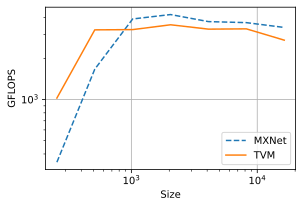

In [10]:
tvm_gflops = d2ltvm.bench_matmul_tvm(matmul_gpu, sizes, 'cuda')
d2ltvm.plot_gflops(sizes, [mxnet_gflops, tvm_gflops], legend=['MXNet', 'TVM'])

## Summary

- We use a two-level block tiling to parallelize matrix multiplication on GPUs.
- We load data used by a thread block into share memory, and data used by a CUDA thread into registers
- The shared data within a thread block is loaded by cooperative fetching.